## 1a) Modelo para dinamica de vuelos de Lobesia botrana sin estructura etaria - en estado natural - (a partir de datos digitalizados)

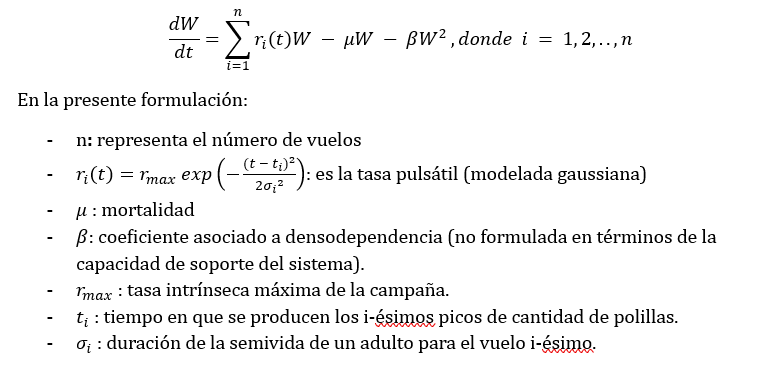

Parámetros optimizados: r_max=1.571,  mu=0.010, beta=0.00931, sigma_vuelos=6.4
RMSE: 70.8, NSE: 0.41


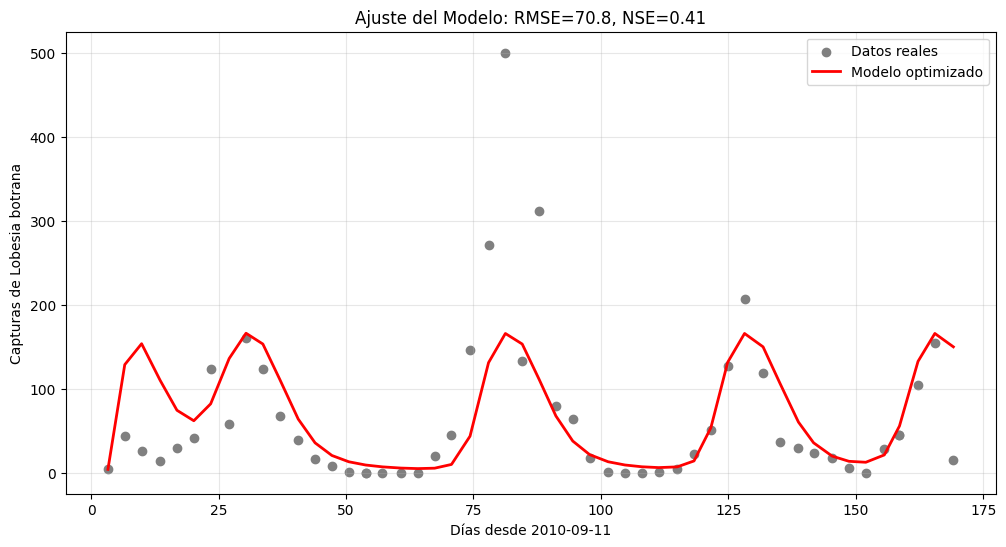

In [ ]:
#########################################################################################################################################
# MODELO 1A - Modelo para dinámica de vuelos de Lobesia botrana en estado natural sin estructura etaria (a partir de datos digitalizados)
#########################################################################################################################################


import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('data_scaled.csv')
t_data = data['dias'].values
W_data = data['y'].values

# Identificar picos para inicializar t_picos
picos = argrelextrema(W_data, np.greater, order=3)[0]
t_picos = t_data[picos]

# Función del modelo (adaptada para curve_fit)
def modelo_ajuste(t, r_max, mu, beta, sigma_vuelos):
    params = {
        'r_max': r_max,
        'mu': mu,
        'beta': beta,
        'sigma_vuelos': sigma_vuelos
    }
    sol = odeint(modelo, W_data[0], t, args=(params,))
    return sol[:, 0]

# Función auxiliar para el modelo ODE (sin cambios)
def modelo(W, t, params):
    r_pulsos = sum(
        params['r_max'] * np.exp(-((t - t_i)**2)/(2*params['sigma_vuelos']**2)) 
        for t_i in t_picos
    )
    dWdt = r_pulsos * W  - params['mu']*W - params['beta']*W**2
    return dWdt

# Parámetros iniciales y límites
p0 = [1, 0.05, 0.001, 5.0]  # Valores iniciales: [r_max, mu, beta, sigma_vuelos]
bounds = (
    [0.1,  0.01, 0.0001, 1.0],  # Límites inferiores
    [3.0,  0.2, 0.01, 10.0]       # Límites superiores
)

# Ajuste de parámetros (Calibracion)
params_opt, params_cov = curve_fit(
    modelo_ajuste, 
    t_data, 
    W_data, 
    p0=p0, 
    bounds=bounds,
    maxfev=1000  # Número máximo de iteraciones
)

# Parámetros optimizados
r_max_opt, mu_opt, beta_opt, sigma_opt = params_opt
print(f"Parámetros optimizados: r_max={r_max_opt:.3f},  mu={mu_opt:.3f}, beta={beta_opt:.5f}, sigma_vuelos={sigma_opt:.1f}")


# Predicciones con parámetros optimizados
W_pred = modelo_ajuste(t_data, *params_opt)

# RMSE
rmse = np.sqrt(np.mean((W_data - W_pred)**2))

# NSE
nse = 1 - (np.sum((W_data - W_pred)**2) / np.sum((W_data - np.mean(W_data))**2))

print(f"RMSE: {rmse:.1f}, NSE: {nse:.2f}")



plt.figure(figsize=(12, 6))
plt.scatter(t_data, W_data, color='gray', label='Datos reales')
plt.plot(t_data, W_pred, 'r-', lw=2, label='Modelo optimizado')
plt.xlabel('Días desde 2010-09-11')
plt.ylabel('Capturas de Lobesia botrana')
plt.title(f'Ajuste del Modelo: RMSE={rmse:.1f}, NSE={nse:.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 1b) Modelo para el control de Lobesia sin estructura etaria - con SIT (sin voltinismo)
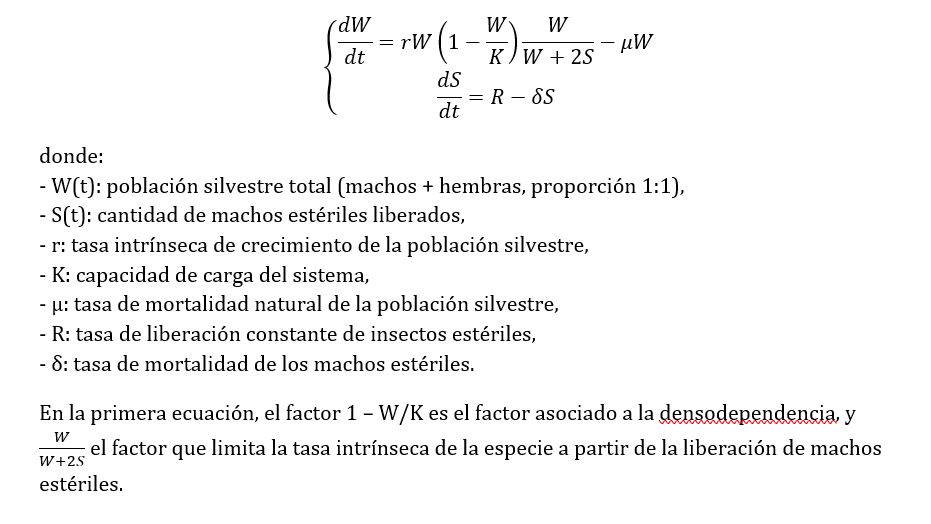

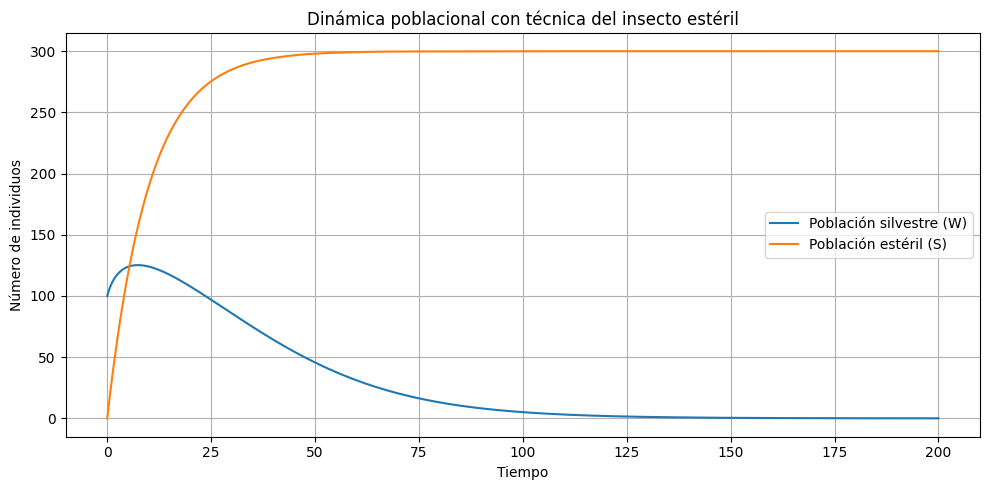

In [ ]:
##########################################################################################
# MODELO 1b - Control de Lobesia botrana sin estructura etaria - con SIT (sin voltinismo)  
##########################################################################################

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parámetros biológicamente razonables
r = 0.2       # tasa intrínseca de crecimiento
K = 1000      # capacidad de carga del ambiente
mu = 0.05     # tasa de mortalidad natural de la población silvestre
R = 30        # tasa de liberación de machos estériles por unidad de tiempo
delta = 0.1   # tasa de mortalidad natural de los estériles

# Sistema de EDOs
def modelo(t, y):
    W, S = y
    dWdt = r * W * (1 - W/K) * (W / (W + 2*S)) - mu * W
    dSdt = R - delta * S
    return [dWdt, dSdt]

# Condiciones iniciales
W0 = 100   # población silvestre inicial
S0 = 0     # población estéril inicial
y0 = [W0, S0]

# Intervalo de tiempo para la simulación
t_span = (0, 200)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Resolución del sistema
sol = solve_ivp(modelo, t_span, y0, t_eval=t_eval)

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Población silvestre (W)')
plt.plot(sol.t, sol.y[1], label='Población estéril (S)')
plt.xlabel('Tiempo')
plt.ylabel('Número de individuos')
plt.title('Dinámica poblacional con técnica del insecto estéril')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 1c) Modelo para el control de Lobesia botrana sin estructura etaria - con SIT (incorporando voltinismo y tasa pulsátil)
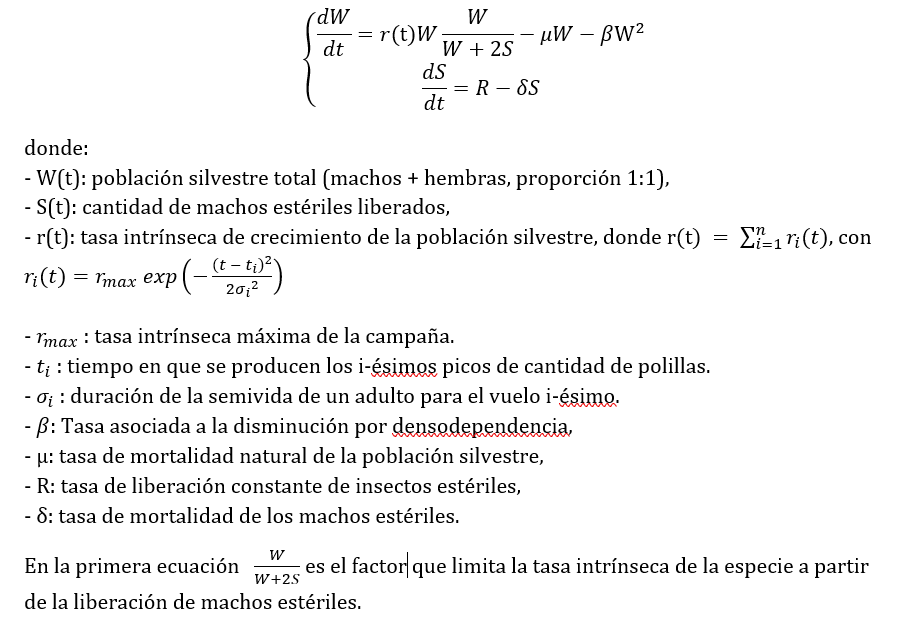

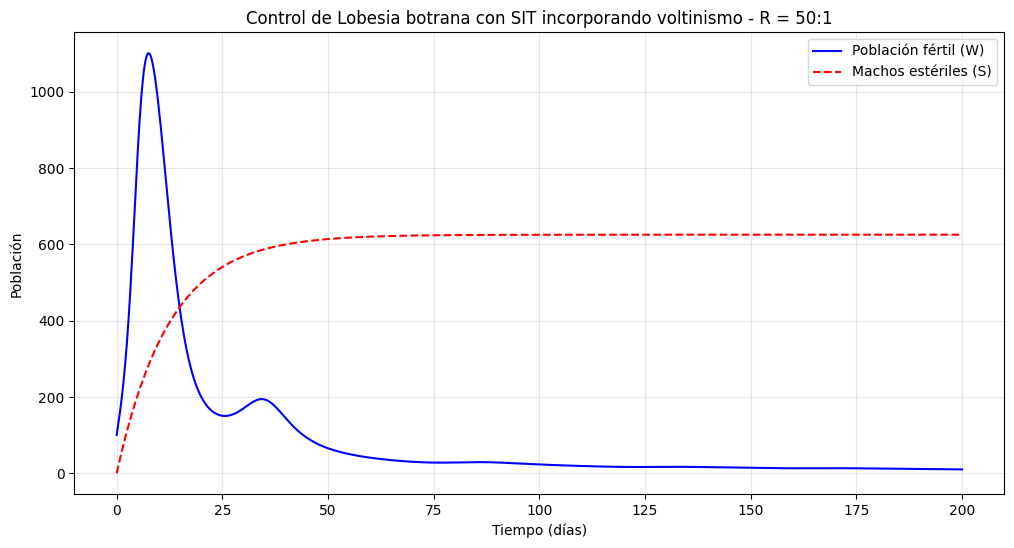

In [ ]:
########################################################################################################################################################
# MODELO 1C - parte A - Modelo para el control de Lobesia botrana sin estructura etaria - con SIT (incorporando voltinismo, tasa pulsátil y R constante)
########################################################################################################################################################

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros ajustados biológicamente
r_max = 1.571       # Tasa máxima de crecimiento por generación
mu = 0.00010        # Tasa de mortalidad natural
beta = 0.000931     # Coeficiente de competencia
delta = 0.08        # Tasa de mortalidad de machos estériles (vida media ~14 días)
R = 50              # Tasa de liberación de machos estériles
sigma_vuelos = 6    # Duración del vuelo adulto (días)
t_picos = [6.61, 30.39, 81.26, 128.17, 165.49]  # Picos de generaciones

def model(y, t):
    W, S = y
    # Suma de pulsos gaussianos para r(t)
    r_pulsos = sum(
        r_max * np.exp(-((t - t_i)**2)/(2 * sigma_vuelos**2)) 
        for t_i in t_picos
    )
    # Ecuación corregida: W/(W + 2S) en lugar de W/(W + S)
    dWdt = r_pulsos * W * (W / (W + 2 * S)) - mu * W - beta * W**2
    dSdt = R - delta * S
    return [dWdt, dSdt]

# Condiciones iniciales
W0 = 100   # Población inicial de insectos
S0 = 0      # Machos estériles iniciales
y0 = [W0, S0]

# Tiempo de simulación
t = np.linspace(0, 200, 1000)

# Resolver el sistema
solution = odeint(model, y0, t)
W, S = solution[:, 0], solution[:, 1]

# Gráficos
plt.figure(figsize=(12, 6))
plt.plot(t, W, 'b-', label='Población fértil (W)')
plt.plot(t, S, 'r--', label='Machos estériles (S)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Población')
plt.title('Control de Lobesia botrana con SIT incorporando voltinismo - R = 50:1')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

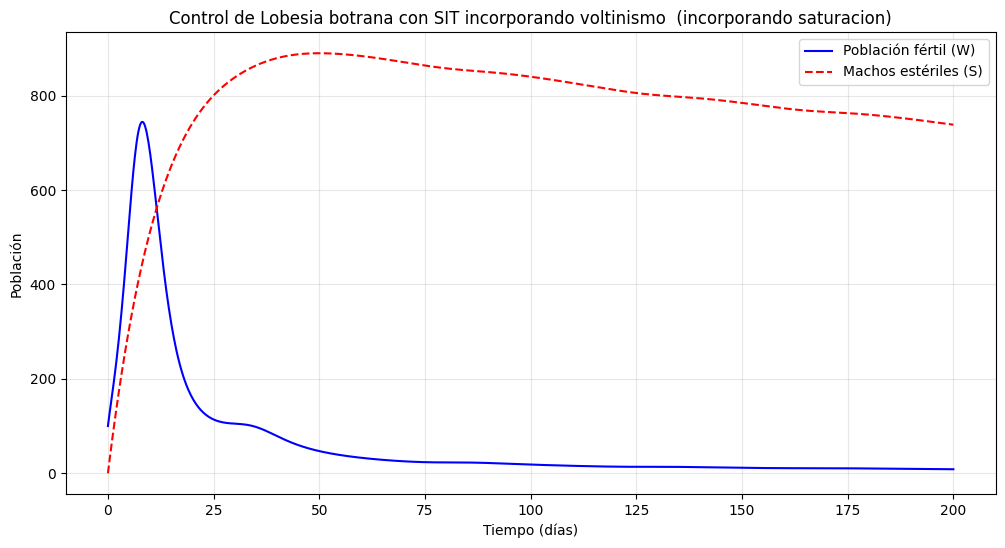

In [ ]:
##########################################################################################################################################################################
# MODELO 1C - parte B- Modelo para el control de Lobesia botrana sin estructura etaria - con SIT (incorporando voltinismo, tasa pulsátil y funcion de generacion variable)
##########################################################################################################################################################################


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros ajustados biológicamente
r_max = 1.571       # Tasa máxima de crecimiento por generación
mu = 0.00010        # Tasa de mortalidad natural
beta = 0.000931     # Coeficiente de competencia
delta = 0.08        # Tasa de mortalidad de machos estériles (vida media ~14 días)
R = 30              # Tasa de liberación de machos estériles
sigma_vuelos = 6    # Duración del vuelo adulto (días)
t_picos = [6.61, 30.39, 81.26, 128.17, 165.49]  # Picos de generaciones

def model(y, t):
    W, S = y
    # Suma de pulsos gaussianos para r(t)
    r_pulsos = sum(
        r_max * np.exp(-((t - t_i)**2)/(2 * sigma_vuelos**2)) 
        for t_i in t_picos
    )
    # Ecuación corregida: W/(W + 2S) en lugar de W/(W + S)
    dWdt = r_pulsos * W * (W / (W + 2 * S)) - mu * W - beta * W**2
    dSdt = R * W / (1 + 0.4 * W)- delta * S
    return [dWdt, dSdt]

# Condiciones iniciales
W0 = 100   # Población inicial de insectos
S0 = 0      # Machos estériles iniciales
y0 = [W0, S0]

# Tiempo de simulación
t = np.linspace(0, 200, 1000)

# Resolver el sistema
solution = odeint(model, y0, t)
W, S = solution[:, 0], solution[:, 1]

# Gráficos
plt.figure(figsize=(12, 6))
plt.plot(t, W, 'b-', label='Población fértil (W)')
plt.plot(t, S, 'r--', label='Machos estériles (S)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Población')
plt.title('Control de Lobesia botrana con SIT incorporando voltinismo  (incorporando saturacion)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 1d) Modelo para el control de Lobesia botrana sin estructura etaria - con Tecnica de confusion sexual (incorporando voltinismo y tasa pulsátil)

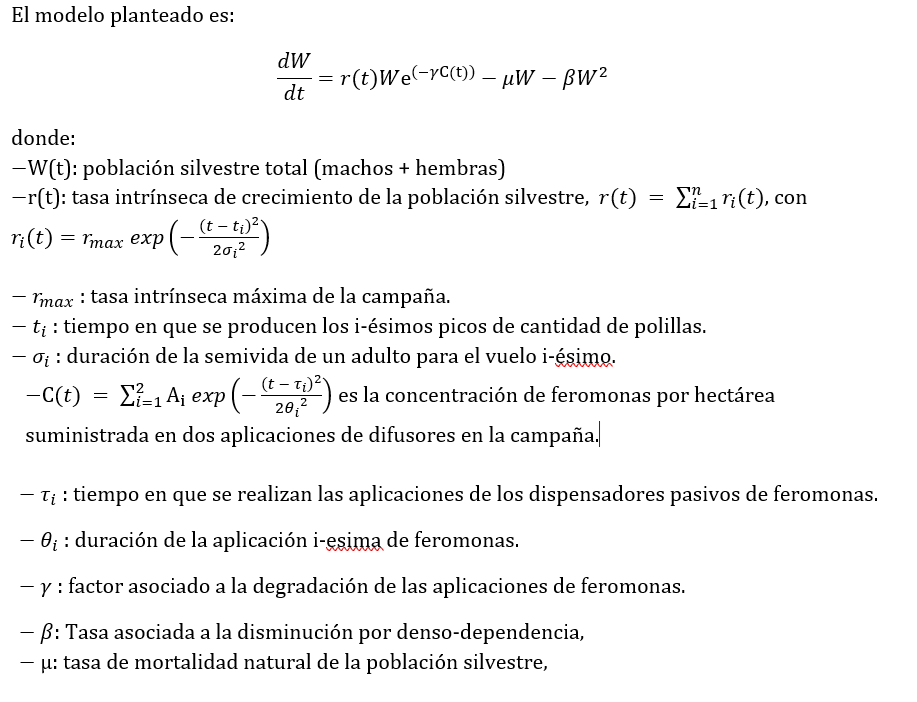

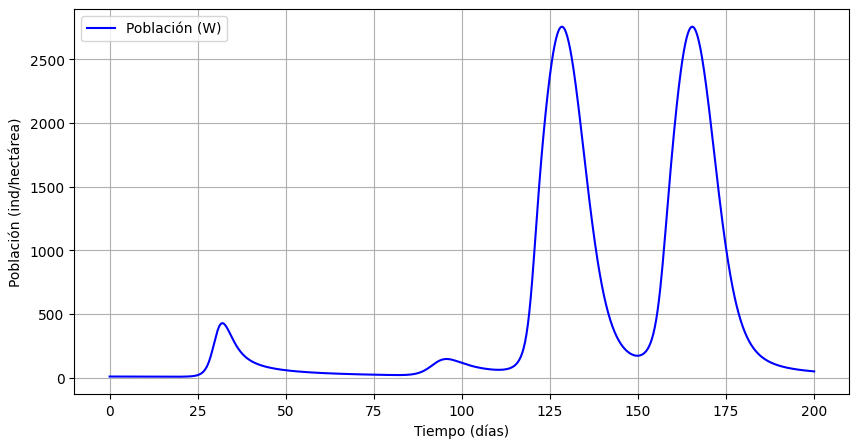

In [ ]:
#############################################################################################################################################################################################################
# MODELO 1D - Modelo para el control de Lobesia botrana sin estructura etaria - con tecnica de confusión sexual (incorporando voltinismo, tasa pulsátil y el efecto de dos aplicaciones de difusores pasivos) 
#############################################################################################################################################################################################################


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros
r_max = 2.571
mu = 0.0010
beta = 0.000931
gamma = 0.005
ti_picos = np.array([7, 30, 81, 128, 165])
sigma_i = 6.4
Ai = [4000, 5000]  # ng/m³
taui = [1, 60]   # días
thetai = [10, 12] # días

# Funciones
def r(t):
    return sum(r_max * np.exp(-(t - ti)**2 / (2 * sigma_i**2)) for ti in ti_picos)  # Corregido: paréntesis balanceados

def C(t):
    return sum(A * np.exp(-(t - tau)**2 / (2 * theta**2)) for A, tau, theta in zip(Ai, taui, thetai))  # Corregido: paréntesis balanceados

def modelo(W, t):
    dWdt = r(t) * W * np.exp(-gamma * C(t)) - mu * W - beta * W**2
    return dWdt

# Condiciones iniciales
W0 = 10  # Población inicial (individuos/hectárea)
t = np.linspace(0, 200, 1000)  # 200 días
sol = odeint(modelo, W0, t)

# Gráficos
plt.figure(figsize=(10, 5))
plt.plot(t, sol, 'b-', label='Población (W)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Población (ind/hectárea)')
plt.legend()
plt.grid()
plt.show()

κ = 1892.30


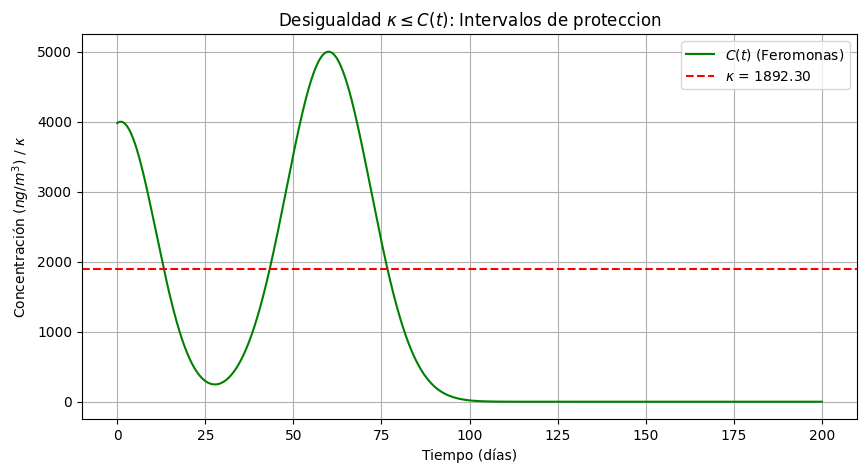


Intervalos donde C(t) >= κ:
[0.0, 13.2] días
[43.3, 76.7] días


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
n = 5

# Calcular kappa
kappa = (1/gamma) * np.log(n * r_max / mu)
print(f"κ = {kappa:.2f}")

# Definir C(t)
def C(t):
    return sum(A * np.exp(-(t - tau)**2 / (2 * theta**2)) for A, tau, theta in zip(Ai, taui, thetai))

# Rango de tiempo
t = np.linspace(0, 200, 5000)  # Mayor resolución para precisión
C_values = [C(ti) for ti in t]

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(t, C_values, 'g-', label='$C(t)$ (Feromonas)')
plt.axhline(y=kappa, color='r', linestyle='--', label=f'$κ$ = {kappa:.2f}')
plt.xlabel('Tiempo (días)')
plt.ylabel('Concentración ($ng/m^3$) / $κ$')
plt.legend()
plt.grid()
plt.title('Desigualdad $κ \leq C(t)$: Intervalos de proteccion')
plt.show()

# Encontrar intervalos donde C(t) >= kappa
above_kappa = np.where(np.array(C_values) >= kappa)[0]
intervals = []
if len(above_kappa) > 0:
    start = t[above_kappa[0]]
    for i in range(1, len(above_kappa)):
        if above_kappa[i] - above_kappa[i-1] > 1:  # Detecta saltos (separación entre pulsos)
            end = t[above_kappa[i-1]]
            intervals.append((start, end))
            start = t[above_kappa[i]]
    intervals.append((start, t[above_kappa[-1]]))  # Último intervalo

print("\nIntervalos donde C(t) >= κ:")
for interval in intervals:
    print(f"[{interval[0]:.1f}, {interval[1]:.1f}] días")